In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets
import numpy as np

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [4]:
raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)


original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,oldpeak
0,63,1,1,145,233,1,2,150,0,3,0,6,2.3
1,67,1,4,160,286,0,2,108,1,2,3,3,1.5
2,67,1,4,120,229,0,2,129,1,2,2,7,2.6
3,37,1,3,130,250,0,0,187,0,3,0,3,3.5
4,41,0,2,130,204,0,2,172,0,1,0,3,1.4


In [5]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 25, activation=activation, input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation=activation,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=50, activation=activation,
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [6]:
## Need to define a scaling function that ignores categorical values...?

In [7]:
nn = build_dnn(num_features=original_data.shape[1], activation="relu")
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                350       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
___________________

Using TensorFlow backend.


In [8]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

In [9]:
# ZScaler.transform(X_train)

In [10]:
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer, analyzer_type="lrp.epsilon")

In [11]:
pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.462, Acc:0.8915
Prediction Accuracy
28/28 [==============================] - 0s 1ms/step
Scores on data set: loss=0.387 accuracy=0.9286
Fold Correct: 26
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.449, Acc:0.8837
Prediction Accuracy
28/28 [==============================] - 0s 21us/step
Scores on data set: loss=0.505 accuracy=0.8214
Fold Correct: 23
Running worker: 2
Fold: 2 -> Loss:0.467, Acc:0.8992
Prediction Accuracy
28/28 [==============================] - 0s 17us/step
Scores on data set: loss=0.653 accuracy=0.8571
Fold Correct: 24
Running worker: 3
Fold: 3 -> Loss:0.478, Acc:0.8760
Prediction Accuracy
27/27 [==============================] - 0s 25us/step
Scores on data set: loss=0.638 accuracy=0.7778
Fold Correct: 21
Running worker: 4
Fold: 4 -> Loss:0.405, Acc:0.8923
Prediction Accuracy
26/26 [=====

Confusion matrix, without normalization
[[0.85416667 0.14583333]
 [0.2195122  0.7804878 ]]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a339d5a58>, array([[123,  21],
        [ 27,  96]]))

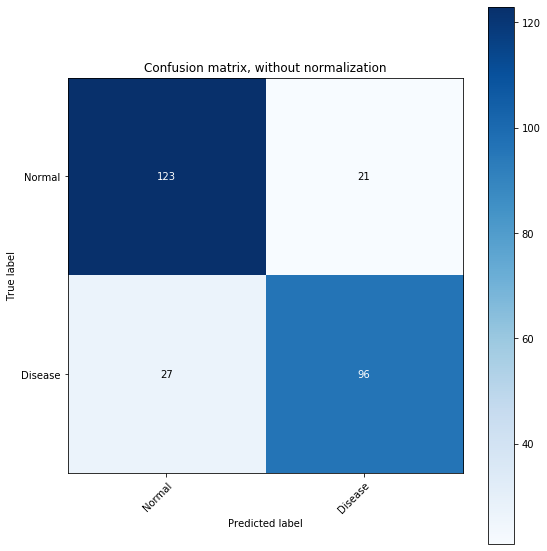

In [12]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [13]:
# pipeline.reducer_pipeline = Pipeline([
#                                 ("umap", umap.UMAP(random_state=42,
#                                                 n_components = 13,
#                                                 n_neighbors=15,
#                                                 min_dist=0)),
#                                ("scaler", MinMaxScaler())
#                             ])
pipeline.train_clusterer(plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:751

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",0,1.0,2147483647,2147483647
"(13, 12)",0,1.0,2147483647,2147483647
"(13, 13)",0,1.0,2147483647,2147483647
"(14, 12)",0,1.0,2147483647,2147483647
"(14, 13)",0,1.0,2147483647,2147483647
"(14, 14)",0,1.0,2147483647,2147483647
"(15, 12)",0,1.0,2147483647,2147483647
"(15, 13)",0,1.0,2147483647,2147483647
"(15, 14)",0,1.0,2147483647,2147483647
"(15, 15)",0,1.0,2147483647,2147483647


In [14]:
pd.Series(pipeline.clusterer.labels_).value_counts()

-1    96
dtype: int64

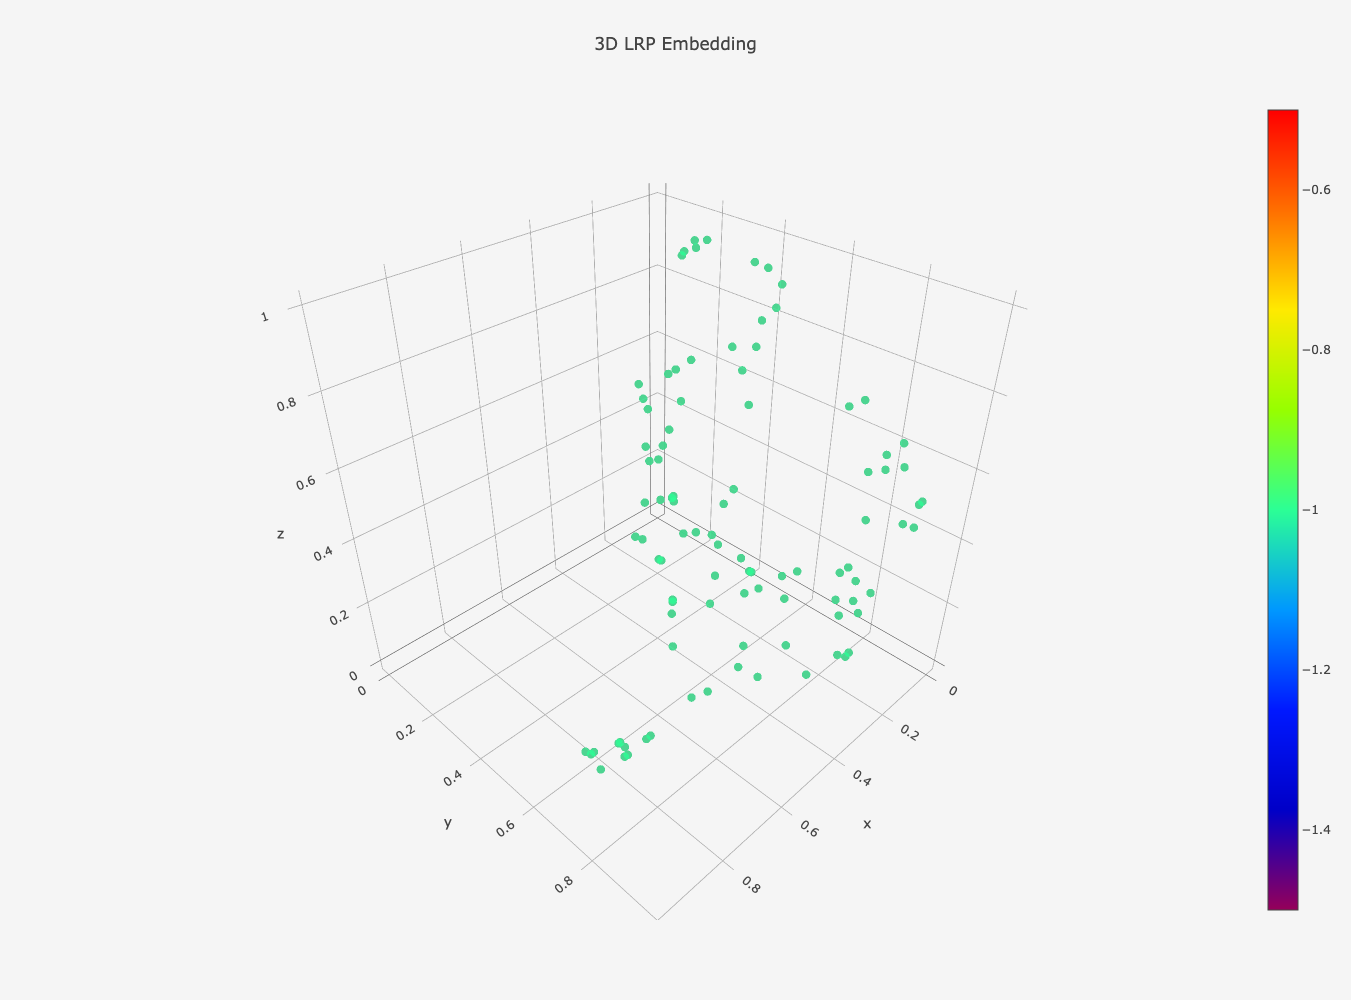

In [15]:
import umap
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])

training_lrp = pipeline.training_lrp
embedding_pipeline.fit(training_lrp)
embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8,
        showscale=True
    ),
    text=pipeline.clusterer.labels_
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


data=[emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-scatter.html')

In [16]:
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!
Prediction Accuracy: 0.8333


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/hdbscan/prediction.py:385: UserWarning:

Clusterer does not have any defined clusters, new data will be automatically predicted as noise.



In [17]:
pd.Series(cluster_labels).value_counts()

-1    11
dtype: int64

## Plotting Testing LRP

In [18]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp

In [19]:
# labels = correct_pred_labels[split_class]
len(training_lrp)

96

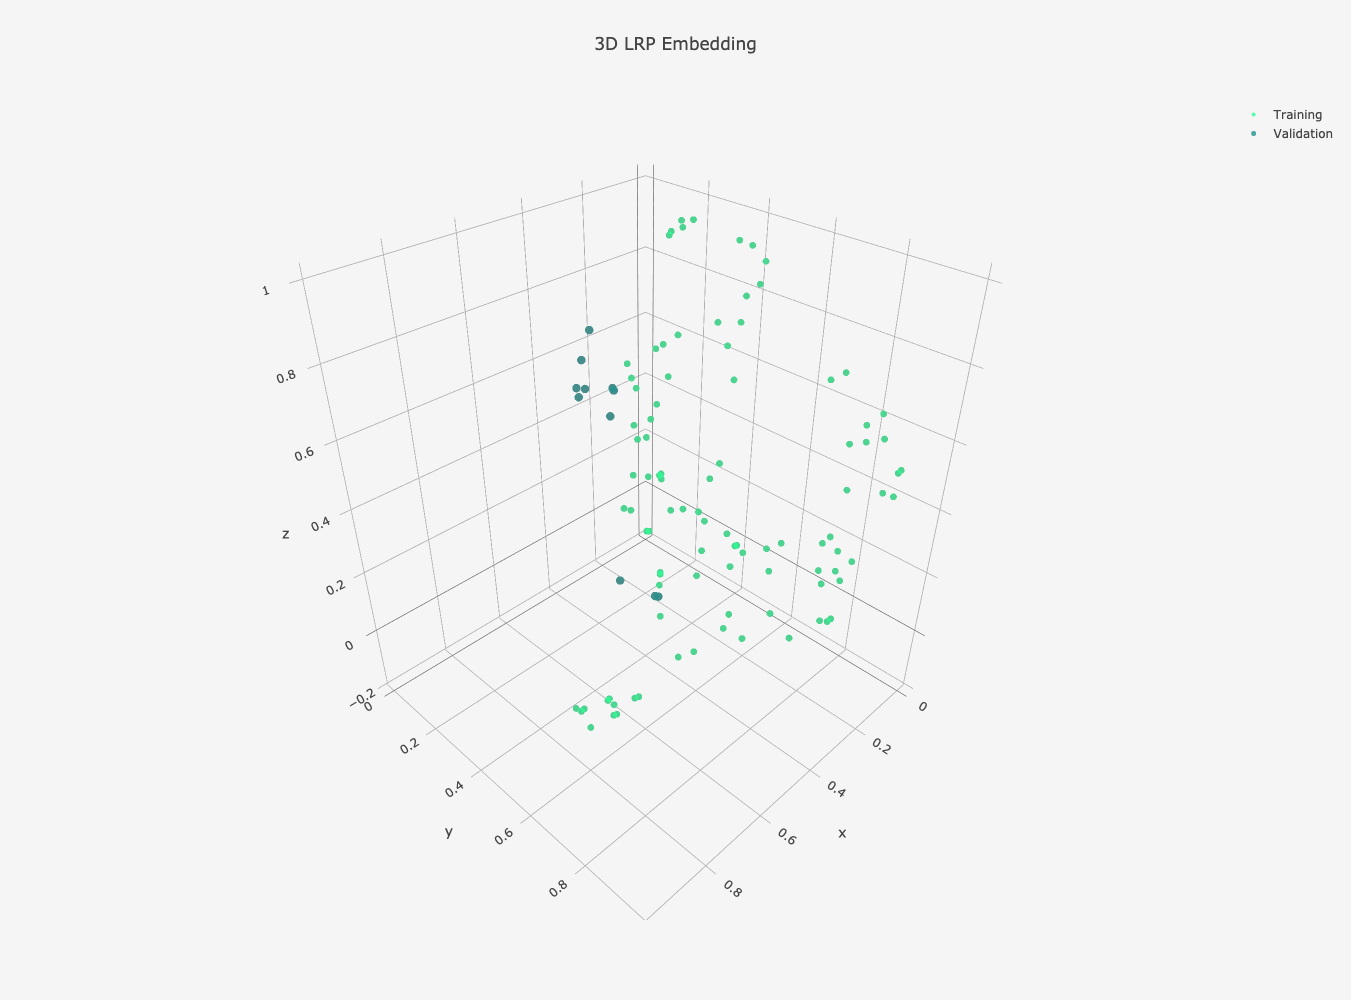

In [20]:
import umap
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline

embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)


# reducer = umap.UMAP(random_state=42,
#                     n_components = 2,
#                     n_neighbors=10,
#                     min_dist=0)

# embedding = reducer.fit_transform(training_lrp)

# emb2d = go.Scatter(
#     x=embedding[:,0],
#     y=embedding[:,1],
#     mode="markers"
# )

# layout = go.Layout(
#     title= "2D LRP Embedding"
# )

# data=[emb2d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig)



embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=4,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-scatter.html')

# Comparing Subclusters to Original Data

In [21]:
y_train.head()

101    0
214    0
206    1
241    0
27     0
Name: target, dtype: int64

In [22]:
original_y = original_labels[y_train.index]
original_y.head()

101    0
214    0
206    1
241    0
27     0
Name: target, dtype: int64

In [23]:
y_train.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr].head()

122    1
24     1
137    1
184    0
260    0
Name: target, dtype: int64

In [24]:
# Get testing samples from cross validation
# That were correctly predicted
correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
split_class = correct_pred_labels == pipeline.target_class

correct_original_target = original_y.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr][split_class]

In [25]:
emb3d["text"] = correct_original_target
emb3d["marker"]["color"] = correct_original_target
emb3d["marker"]["showscale"] = True
emb3d["marker"]["size"] = 5
emb3d["marker"]["colorscale"] = "Viridis"

fig = go.Figure(data=[emb3d], layout=layout)
# iplot(fig, filename='lrp-vs-original.html')

## Calculating entropy of the relevance distributions

In [26]:
relevance_embedding = embedding#pipeline.reducer_pipeline.transform(pipeline.training_lrp)
relevance_embedding.shape

(96, 3)

In [37]:
'''
Non-parametric computation of entropy and mutual-information

Adapted by G Varoquaux for code created by R Brette, itself
from several papers (see in the code).

These computations rely on nearest-neighbor statistics
'''
import numpy as np

from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi

from sklearn.neighbors import NearestNeighbors

__all__=['entropy', 'mutual_information', 'entropy_gaussian']

EPS = np.finfo(float).eps


def nearest_distances(X, k=1):
    '''
    X = array(N,M)
    N = number of points
    M = number of dimensions

    returns the distance to the kth nearest neighbor for every point in X
    '''
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    d, _ = knn.kneighbors(X) # the first nearest neighbor is itself
    return d[:, -1] # returns the distance to the kth nearest neighbor

def entropy(X, k=1):
    ''' Returns the entropy of the X.

    Parameters
    ===========

    X : array-like, shape (n_samples, n_features)
        The data the entropy of which is computed

    k : int, optional
        number of nearest neighbors for density estimation

    Notes
    ======

    Kozachenko, L. F. & Leonenko, N. N. 1987 Sample estimate of entropy
    of a random vector. Probl. Inf. Transm. 23, 95-101.
    See also: Evans, D. 2008 A computationally efficient estimator for
    mutual information, Proc. R. Soc. A 464 (2093), 1203-1215.
    and:
    Kraskov A, Stogbauer H, Grassberger P. (2004). Estimating mutual
    information. Phys Rev E 69(6 Pt 2):066138.
    '''

    # Distance to kth nearest neighbor
    r = nearest_distances(X, k) # squared distances
    n, d = X.shape
    volume_unit_ball = (pi**(.5*d)) / gamma(.5*d + 1)
    '''
    F. Perez-Cruz, (2008). Estimation of Information Theoretic Measures
    for Continuous Random Variables. Advances in Neural Information
    Processing Systems 21 (NIPS). Vancouver (Canada), December.

    return d*mean(log(r))+log(volume_unit_ball)+log(n-1)-log(k)
    '''
    return (d*np.mean(np.log(r + np.finfo(X.dtype).eps))
            + np.log(volume_unit_ball) + psi(n) - psi(k))


import scipy.spatial as ss
from scipy.special import digamma
from math import log

# UTILITY FUNCTIONS

def add_noise(x, intens=1e-10):
    # small noise to break degeneracy, see doc.
    return x + intens * np.random.random_sample(x.shape)

def query_neighbors(tree, x, k):
    return tree.query(x, k=k + 1, p=float('inf'), n_jobs=-1)[0][:, k]

# CONTINUOUS ESTIMATORS

def diff_entropy(x, k=3, base=2):
    """ The classic K-L k-nearest neighbor continuous entropy estimator
        x should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
        if x is a one-dimensional scalar and we have four samples
    """
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x = np.asarray(x)
    n_elements, n_features = x.shape
    x = add_noise(x)
    tree = ss.cKDTree(x)
    nn = query_neighbors(tree, x, k)
    const = digamma(n_elements) - digamma(k) + n_features * log(2)
    return (const + n_features * np.log(nn).mean()) / log(base)

print("Embedding Entropy: {:.4f}".format(entropy(relevance_embedding, k=25)))
print("Differential Entropy: {:.4f}".format(diff_entropy(relevance_embedding, k=50)))
print("Original Entropy: {:.4f}".format(entropy(training_lrp, k=50)))
print("Differential Entropy: {:.4f}".format(diff_entropy(training_lrp, k=15)))

Embedding Entropy: 0.4318
Differential Entropy: 1.4260
Original Entropy: 4.9957
Differential Entropy: 8.0524


In [32]:
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
    
nsamples = len(relevance_embedding)

# nbins  = 30
# xedges = np.linspace(0,1,nbins+1)
# yedges = np.linspace(0,1,nbins+1)
# zedges = np.linspace(0,1,nbins+1)

# axes_ = [x.ravel() for x in np.meshgrid(xedges,yedges,zedges)]

# grid = np.array([x for x in zip(*axes_)])

nbins  = 200
grid, edges = np.histogramdd(relevance_embedding, bins=nbins)
densities = (grid/nsamples).flatten()

In [33]:
entropy(densities)

4.564348191467842

In [59]:
# kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(relevance_embedding)
# train_densities = kde.score_samples(relevance_embedding)
# densities = np.exp(kde.score_samples(grid))

In [60]:
# # pd.DataFrame(densities[densities > 0]).plot()
# emb3d["marker"]["color"] = train_densities
# emb3d["marker"]["showscale"]=True
# emb3d["marker"]["colorscale"]="Reds"

# data=[emb3d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='lrp-densities.html')

In [61]:
# entropy(densities)

In [62]:
%%time

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                              covariance_type=cv_type)
        gmm.fit(relevance_embedding)
        bic.append(gmm.bic(relevance_embedding))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
best_gmm

CPU times: user 102 ms, sys: 4.61 ms, total: 106 ms
Wall time: 114 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

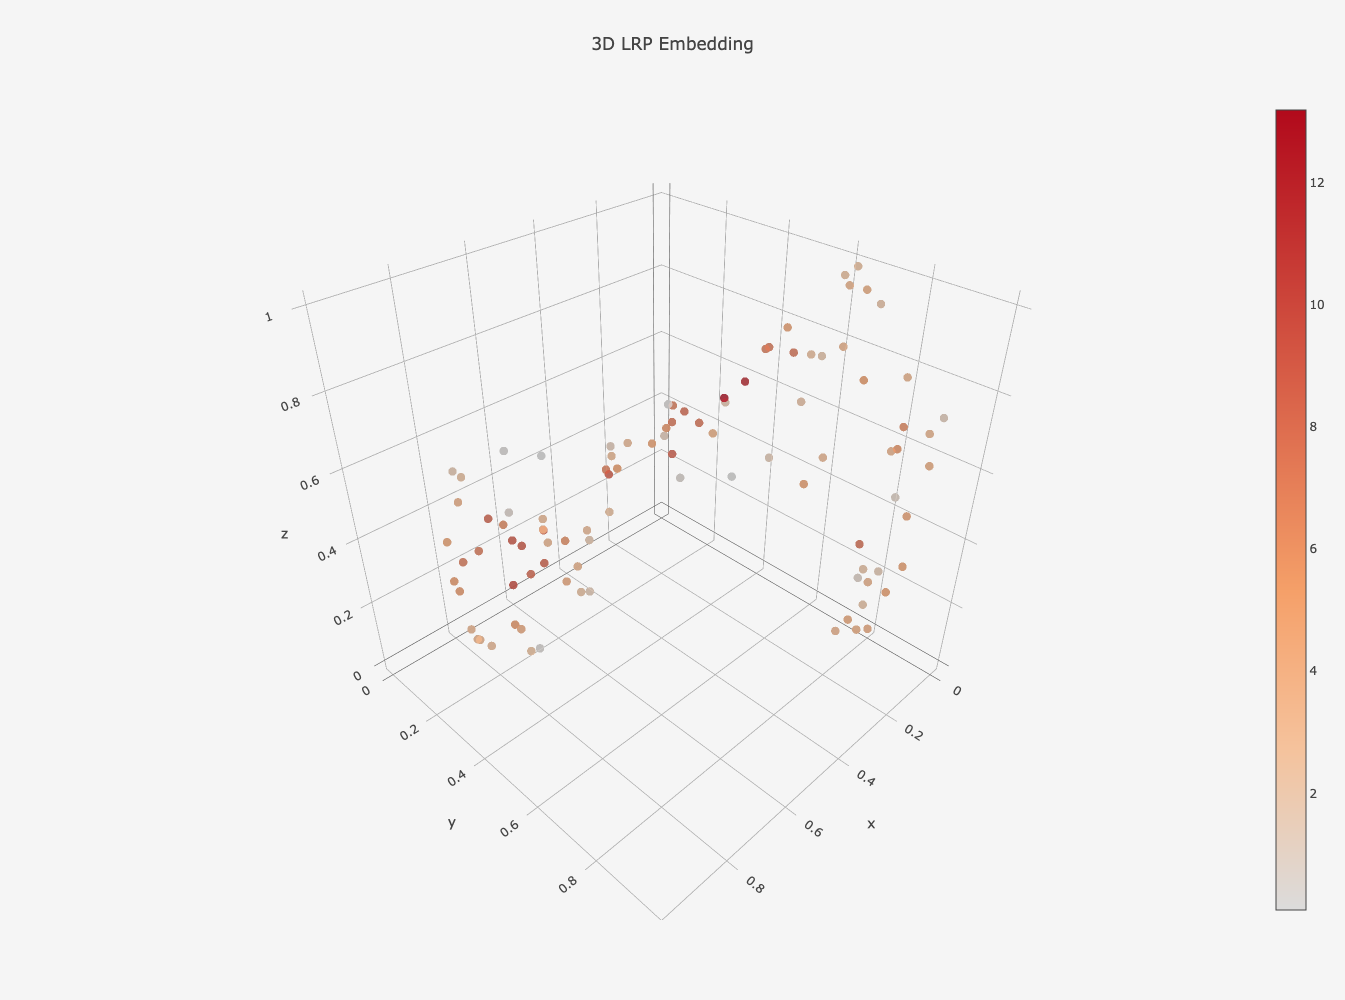

Entropy: 4.375832348360106


In [41]:
gmm_train_densities = np.exp(best_gmm.score_samples(relevance_embedding))
# gmm_densities = np.exp(best_gmm.score_samples(grid))

emb3d["marker"]["color"] = gmm_train_densities
emb3d["marker"]["showscale"]=True
emb3d["marker"]["colorscale"]="Reds"

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-densities.html')
print("Entropy:", entropy(gmm_train_densities))

In [ ]:
np.max(best_gmm.score_samples(grid))

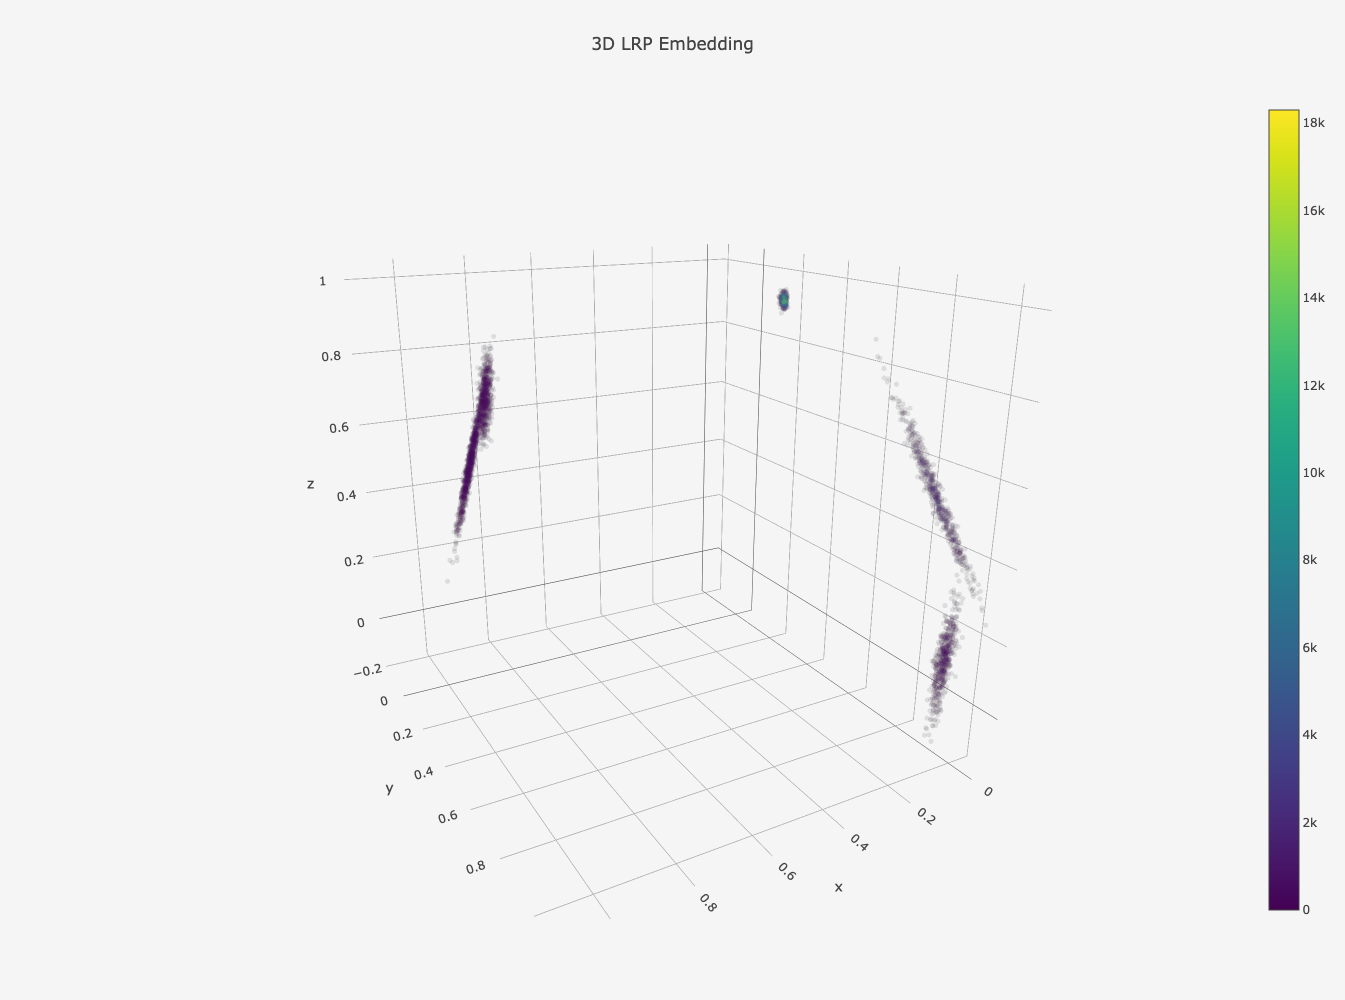

In [62]:
#Plot samples from these density estimates
gmm_samples,_ = best_gmm.sample(3000)
gmm_probs = np.exp(best_gmm.score_samples(gmm_samples))


grid_pts = go.Scatter3d(
    x=gmm_samples[:,0],
    y=gmm_samples[:,1],
    z=gmm_samples[:,2],
    mode="markers",
    name="GMM Density Estimate of Relevance",
    marker=dict(
        size=3,
        color=gmm_probs,
        colorscale="Viridis",
        opacity=0.1,
        showscale=True
    ),
    text=gmm_probs
)

fig = go.Figure(data=[grid_pts], layout=layout)
iplot(fig, filename='lrp-densities.html')